# Worksheet 17

Name: Alexander Miller
UID: U52161825

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

1. **Collaborative Filtering:** This method makes automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating). The underlying assumption is that if a user A has the same opinion as a user B on an issue, A is more likely to have B's opinion on a different issue. In the context of a "like" or "dislike" system, if user A likes the same movies as user B, then the movies that user B likes that user A hasn't yet watched may be recommended to user A.

2. **Content-Based Filtering:** This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In the context of a "like" or "dislike" system, if user A likes a certain kind of movies, then similar movies can be recommended to user A.

In both cases, the system would use the "like" or "dislike" data to learn about user preferences and make recommendations based on those preferences. The "like" could be treated as a positive signal (e.g., a "1") and the "dislike" as a negative signal (e.g., a "0"), and these signals could be used to train a machine learning model to predict what other items a user might like or dislike.

b) Describe 3 challenges of building a recommender system

1. **Data Sparsity:** Most users only interact with a small subset of the total items available, leading to a sparse user-item interaction matrix. This sparsity can make it difficult to find similar items or users, which are key to making accurate recommendations.

2. **Cold Start Problem:** This refers to the difficulty of making recommendations for new users or new items because there is not yet any interaction data to base recommendations on. For new users, also known as the user cold-start problem, the system knows nothing about the user preferences. For new items, also known as the item cold-start problem, the system does not know which users would prefer this item.

3. **Scalability:** As the number of users and items grows, providing recommendations quickly and in real-time can become computationally difficult. The system needs to be able to handle a large amount of data and still provide recommendations in a reasonable time.

c) Why is SVD not an option for collaborative filtering?

1. **Data Sparsity:** SVD is not well-suited to handle sparse data, which is a common characteristic of user-item interaction matrices in collaborative filtering. Most users only rate a few items, leaving the majority of the matrix empty. SVD does not handle these missing values well.

2. **Scalability:** SVD can be computationally expensive, especially for large matrices. This can make it impractical for use in collaborative filtering where the user-item matrix can be very large.

3. **Dynamic Updates:** In a real-world recommender system, user-item interactions are constantly being added. SVD is not ideal for such situations because you would need to recompute the decomposition every time a new rating is added, which is not efficient.

d) Use the code below to train a recommender system on a dataset of amazon movies

/usr/local/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
/usr/local/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Kaggle RMSE = 4.196141084377407


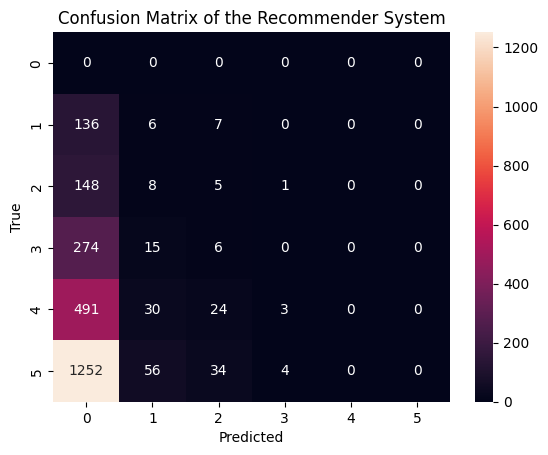

In [4]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)

from pyspark.ml.evaluation import RegressionEvaluator

# Uncomment and complete the hyperparameter tuning part
param_grid = ParamGridBuilder().addGrid(als.rank, [10, 50]).addGrid(als.regParam, [0.1]).addGrid(als.maxIter, [10]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Score", predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# Predictions on the test set
test_df = spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])
predictions = rec_sys.transform(test_df).toPandas()

# Join predictions back to the test set to ensure all user-item pairs are accounted for
X_test_processed = X_test_processed.merge(predictions, on=['UserId_fact', 'ProductId_fact'], how='left')

# Handle missing (NaN) predictions
default_value = 0  # or use: init_df['Score'].mean()
X_test_processed['prediction'] = X_test_processed['prediction'].fillna(default_value)

# Round predictions to the nearest integer since ratings are typically integers
X_test_processed['prediction'] = X_test_processed['prediction'].round()

print("Kaggle RMSE =", mean_squared_error(Y_test, X_test_processed['prediction'], squared=False))

# Due to the nature of recommender systems, a traditional confusion matrix might not be very informative.
# It's better to stick with RMSE as the primary metric. However, if you still want to see a confusion matrix:
cm = confusion_matrix(Y_test, X_test_processed['prediction'])
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix of the Recommender System')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
